In [1]:
pip install pytorch-fid

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),          # 转换为Tensor并归一化到[0,1]
    transforms.Normalize((0.5,), (0.5,))  # 归一化到[-1,1]
])

# 加载MNIST数据集
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# 创建DataLoader
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.83MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.6MB/s]


In [3]:
import os
from torchvision.utils import save_image

# 创建保存真实图像的文件夹
real_mnist_path = "./real_mnist"
os.makedirs(real_mnist_path, exist_ok=True)

# 保存测试集图像（通常用测试集评估生成效果）
for idx, (image, _) in enumerate(test_dataset):
    save_image(image, os.path.join(real_mnist_path, f"{idx}.png"))
    if idx >= 99:  # 限制数量（FID计算通常需要1w张）
        break

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 下采样（编码器）
        self.down1 = self._block(1, 64)
        self.down2 = self._block(64, 128)
        self.down3 = self._block(128, 256)
        # 上采样（解码器）
        self.up1 = self._block(256 + 128, 128)
        self.up2 = self._block(128 + 64, 64)
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x, t):
        # 实际实现中需嵌入时间步t（此处简化）
        x1 = self.down1(x)
        x2 = self.down2(F.max_pool2d(x1, 2))
        x3 = self.down3(F.max_pool2d(x2, 2))

        x = F.interpolate(x3, scale_factor=2)
        x = torch.cat([x, x2], dim=1)
        x = self.up1(x)
        x = F.interpolate(x, scale_factor=2)
        x = torch.cat([x, x1], dim=1)
        x = self.up2(x)
        return self.final(x)

In [5]:
class Diffusion:
    def __init__(self, steps=1000, beta_start=1e-4, beta_end=0.02, device="cuda"):
        self.steps = steps
        self.betas = torch.linspace(beta_start, beta_end, steps).to(device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.device = device

    def forward_process(self, x, t):
        noise = torch.randn_like(x).to(self.device)
        alpha_bar = self.alpha_bars[t].view(-1, 1, 1, 1)
        noisy_x = torch.sqrt(alpha_bar) * x + torch.sqrt(1 - alpha_bar) * noise
        return noisy_x, noise

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet().to(device)
diffusion = Diffusion(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20
for epoch in range(num_epochs):
    for images, _ in train_loader:
        images = images.to(device)
        t = torch.randint(0, diffusion.steps, (images.shape[0],)).to(device)
        noisy_images, noise = diffusion.forward_process(images, t)
        pred_noise = model(noisy_images, t)
        loss = F.mse_loss(pred_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.0416
Epoch 1, Loss: 0.0354
Epoch 2, Loss: 0.0330
Epoch 3, Loss: 0.0427
Epoch 4, Loss: 0.0320
Epoch 5, Loss: 0.0273
Epoch 6, Loss: 0.0304
Epoch 7, Loss: 0.0280
Epoch 8, Loss: 0.0306
Epoch 9, Loss: 0.0272
Epoch 10, Loss: 0.0308
Epoch 11, Loss: 0.0260
Epoch 12, Loss: 0.0266
Epoch 13, Loss: 0.0286
Epoch 14, Loss: 0.0269
Epoch 15, Loss: 0.0229
Epoch 16, Loss: 0.0265
Epoch 17, Loss: 0.0243
Epoch 18, Loss: 0.0318
Epoch 19, Loss: 0.0312


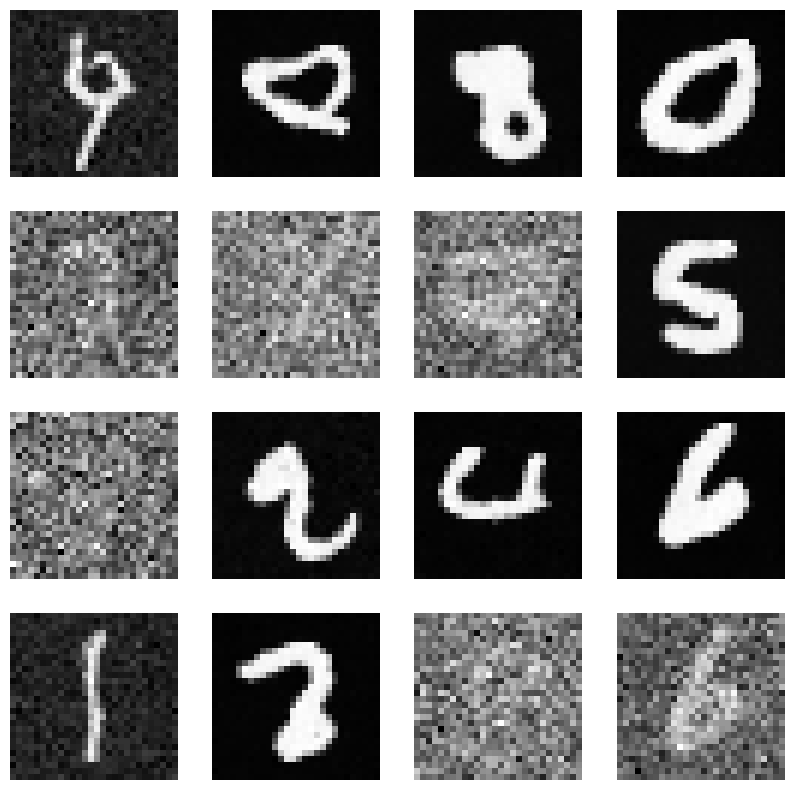

In [7]:
def sample(model, diffusion, num_samples=16, image_size=(28, 28)):
    model.eval()
    with torch.no_grad():
        samples = torch.randn(num_samples, 1, *image_size).to(diffusion.device)
        for t in reversed(range(diffusion.steps)):
            noise_pred = model(samples, torch.full((num_samples,), t, device=diffusion.device))
            alpha = diffusion.alphas[t]
            alpha_bar = diffusion.alpha_bars[t]
            noise = torch.randn_like(samples) if t > 0 else 0
            samples = (1 / torch.sqrt(alpha)) * (samples - ((1 - alpha) / torch.sqrt(1 - alpha_bar)) * noise_pred) + torch.sqrt(diffusion.betas[t]) * noise
    return samples.cpu()

# 生成并可视化图像
generated_images = sample(model, diffusion)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_images[i].squeeze(), cmap="gray")
    plt.axis("off")
plt.show()

In [8]:
generated_mnist_path = "./generated_mnist"
os.makedirs(generated_mnist_path, exist_ok=True)

# 生成并保存图像
generated_images = sample(model, diffusion, num_samples=100)  # 生成1w张
for idx, img in enumerate(generated_images):
    save_image(img, os.path.join(generated_mnist_path, f"{idx}.png"))

In [9]:
from pytorch_fid import fid_score

# 计算FID（确保两个路径已存在）
fid_value = fid_score.calculate_fid_given_paths(
    [real_mnist_path, generated_mnist_path],
    batch_size=50,
    device=device,
    dims=2048  # InceptionV3的特征维度
)
print(f"FID Score: {fid_value:.2f}")

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 336MB/s]
100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


FID Score: 132.43
